In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

In [2]:
# STARTING INPUTS
TailingTonnage = 55774649
MissedGoldGrade = 0.3       # Estimated ppm, g/t
UncapturedWGrade = 300      # Estimated ppm. g/t

SpotGoldPrice = 1000        # USD/Oz
SpotTungstenPrice = 320     # USD/metric ton unit of WO3

FractionReprocessed = pd.DataFrame({'Reprocessed':[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]})
num_obs = 0

In [3]:
# Calculates the total value contained in the tailings
# based on the total tonnage, mineral grades, and spot prices
#
# gold_grade: grade of gold left in tailings, estimated in ppm, g/t
# gold_price: spot price of gold, in USD/Oz
#
# tungsten_grade: grade of tungsten (WO3) in the tailings, estimated ppm, g/t
# tungsten_price: spot price of tungsten (WO3), in USD/metric ton unit of WO3
#
# returns Full value in tailings, in $Million US
#
def CalculateTailingValue(gold_grade,
                          tungsten_grade,
                          gold_price=1000,
                          tungsten_price=320,
                          in_millions=True):
    
    ValueAUPerTonneTailings = gold_grade * gold_price/31.1               # In USD/t
    ValueWPerTonneTailings  = tungsten_grade * tungsten_price/7.93/1000  # In USD/t
    CombinedValuePerTonne = ValueAUPerTonneTailings + ValueWPerTonneTailings
    
    FullValue = TailingTonnage * CombinedValuePerTonne    # In $US
    if (in_millions):
        FullValue = FullValue / 1000000                       # In $M US
    
    return FullValue;

In [4]:
# Creates a dataset that contains a the tailing value based on a fractional amount
# of the tailings processed, and a fraction recovery amount.
#
# returns DataFrame of all tailing values based on fraction reprocessed and recovered.
#
def BuildData(tailings_value, recovery_percent, text=''):
    df = pd.DataFrame()
    
    if (text == ''):
        text = 'Obs{}_RC{}'.format(num_obs,recovery_percent)
        
    for i in FractionReprocessed['Reprocessed']:
        df[text] = FractionReprocessed * tailings_value * recovery_percent

    return df

In [5]:
# prepare the inputs widgets

# text inputs for grade levels
gold_label = widgets.Text('Remaining Gold Grade (in ppm, t/g)')
gold_label.border_style = 'none'
gold_label.disabled = True

tungsten_label = widgets.Text('Remaining Tungsten Grade (in ppm, t/g)')
tungsten_label.border_style = 'none'
tungsten_label.disabled = True

# text inputs for grade levels
gold_grade_input = widgets.FloatText(value=0.3)      #, description='Remaining Gold Grade (in ppm, t/g)')
tungsten_grade_input = widgets.FloatText(value=300)  #, description='Remaining Tungsten Grade (in ppm, t/g)')

hbox1 = widgets.HBox([gold_label, gold_grade_input,tungsten_label, tungsten_grade_input])

# slider inputs for spot prices
gold_price_slider = widgets.FloatSlider(min=100, max=2000, value=1000,
                                        description='Gold Spot Price ($US/Oz)') 
tungsten_price_slider = widgets.FloatSlider(min=50, max=500, value=320,
                                            description='Tungsten Spot Price ($US/metric ton)')

# add a button to refresh the chart.
button = widgets.Button(description='Refresh Chart', background_color='lightblue')

# add a recovered slider
recovery_slider = widgets.FloatSlider(min=0, max=100, value=100,
                                        description='Recovery Percent')

interactions = widgets.VBox([hbox1, gold_price_slider, tungsten_price_slider, recovery_slider, button])

C:\Anaconda3\lib\site-packages\pandas\core\internals.py:1031: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._try_coerce_result(func(values, other))


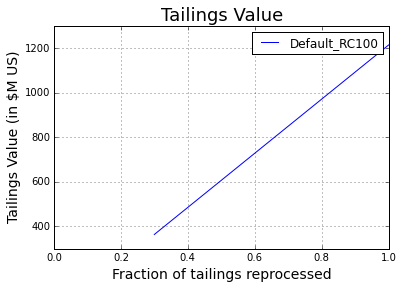

In [6]:
data = pd.DataFrame()
x = FractionReprocessed['Reprocessed'].values

# display the interactive controls
display(interactions)

#preparing the plot 
plots = dict()
fig, ax = plt.subplots()
ax.set_xlabel('Fraction of tailings reprocessed', size=14);
ax.set_xlim(0, 1)
ax.set_ylabel('Tailings Value (in $M US)', size=14);
ax.set_title('Tailings Value', size=18);
ax.grid(True)

# build first set based on starting inputs
tailings = CalculateTailingValue(gold_grade=MissedGoldGrade, tungsten_grade=UncapturedWGrade, 
                                 gold_price=SpotGoldPrice, tungsten_price=SpotTungstenPrice)

text = 'Default_RC100'
data = data.append(BuildData(tailings, 1.0, text))
data[text] = data[text].astype(float)
ax.plot(x, data[text], label=text)
plt.legend()
plt.draw()

# adds the data to the chart
def AppendData(_):
    tailings = CalculateTailingValue(gold_grade=gold_grade_input.value,
                          tungsten_grade=tungsten_grade_input.value,
                          gold_price=gold_price_slider.value,
                          tungsten_price=tungsten_price_slider.value)

    text = 'Obs_RC{0:.1f}'.format(recovery_slider.value)
    data = BuildData(tailings, recovery_slider.value/100, text)
    data[text] = data[text].astype(float)
    ax.plot(x, data[text], label=text)
    plt.legend()
    plt.draw()
# when the button is clicked...
button.on_click(AppendData)